#### Final Project for Human Data Analytics course, a.y. 2019/2020

#### University of Padua - Department of Mathematics

# Locomotion modes recognition on subsets of Opportunity dataset

## Preprocessing (1/3)

*Alberto Bernardi* \\
alberto.bernardi.6@studenti.unipd.it

*Stefano Della Morte* \\
stefano.dellamorte@studenti.unipd.it



In this notebook we do the following tasks:
* download the Opportunity dataset from UCI Machine Learning repository;
* briefly explore the signals using a plot and gathering some extra information;
* define the preprocessing pipeline: Null values filling, splitting some signals into low and high frequencies components, computing accelerometer angle transformation on low passed signals, eventually transform time series in to statistics;
* segment the dataset in time windows and apply preprocessing to each one;
* store the instances for future use.

This notebook is available also on Google Colab (barring removal by owners) at [this link](https://colab.research.google.com/drive/1iNZN0DZq9I8prnEf07IbGHEVx0bHHGwi?usp=sharing).

The next notebook, model design and training, is `Models.ipynb` if running in local or [here](https://colab.research.google.com/drive/11YslYdPONF6ajAnnB-actRCkZrFdelp_?usp=sharing) if using Colab.

Notice that in both cases a folder for storing the dataset (and eventually also plots and models) is required. If using Colab use the provided cell to mount Google Drive or upload the Pickle files (~3GB each dataset) on the remote machine.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from glob import glob
import os
import datetime
from tqdm.notebook import tqdm
from sklearn.preprocessing import OneHotEncoder
from scipy import signal
sn.set()

In [ ]:
# Run this cell for mounting Google Drive on the remote machine
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
DIR_PATH = './'

# Dataset

## Feature lists
Run the following cell to define some useful variables, suited for sensor selection.

In [ ]:
RKN1_acc = list(range(1,4)) 
HIP_acc = list(range(4,7))
LUA_acc = list(range(7,10))
RUA_acc = list(range(10,13))
LH_acc = list(range(13,16)) 
BACK_acc = list(range(16,19))
RKN2_acc = list(range(19,22))
RWR_acc = list(range(22,25))
RUA_acc = list(range(25,28))
LUA_acc = list(range(28,31))
LWR_acc = list(range(31,34))
RH_acc = list(range(34,37))
IMU_BACK_acc = list(range(37,40))
IMU_BACK_gyr = list(range(40,43))
IMU_BACK_mag = list(range(43,46))
IMU_BACK_Qua = list(range(46,50))
IMU_RUA_acc = list(range(50,53))
IMU_RUA_gyr = list(range(53,56))
IMU_RUA_mag = list(range(56,59))
IMU_RUA_Qua = list(range(59,63))
IMU_RLA_acc = list(range(63,66))
IMU_RLA_gyr = list(range(66,69))
IMU_RLA_mag = list(range(69,72))
IMU_RLA_Qua = list(range(72,76))
IMU_LUA_acc = list(range(76,79))
IMU_LUA_gyr = list(range(79,82))
IMU_LUA_mag = list(range(82,85))
IMU_LUA_Qua = list(range(85,89))
IMU_LLA_acc = list(range(89,92))
IMU_LLA_gyr = list(range(92,95))
IMU_LLA_mag = list(range(95,98))
IMU_LLA_Qua = list(range(98,102))
L_SHOE_EuX = list(range(102,105))
L_SHOE_Nav = list(range(105,108))
L_SHOE_Bod = list(range(108,111))
L_SHOE_Ang_Bod = list(range(111,114))
L_SHOE_Ang_Nav = list(range(114,117))
L_SHOE_Compass = [117]
R_SHOE_EuX = list(range(118,121))
R_SHOE_Nav = list(range(121,124))
R_SHOE_Bod = list(range(124,127))
R_SHOE_Ang_Bod = list(range(127,130))
R_SHOE_Ang_Nav = list(range(130,133))
R_SHOE_Compass = [133]
CUP_acc = list(range(134,137))
CUP_gyr = list(range(137,139))
SALAMI_acc = list(range(139,142))
SALAMI_gyr = list(range(142,144))
WATER_acc = list(range(144,147))
WATER_gyr = list(range(147,149))
CHEESE_acc = list(range(149,152))
CHEESE_gyr = list(range(152,154))
BREAD_acc = list(range(154,157))
BREAD_gyr = list(range(157,159))
KNIFE1_acc = list(range(159,162))
KNIFE1_gyr = list(range(162,164))
MILK_acc = list(range(164,167))
MILK_gyr = list(range(167,169))
SPOON_acc = list(range(169,172))
SPOON_gyr = list(range(172,174))
SUGAR_acc = list(range(174,177))
SUGAR_gyr = list(range(177,179))
KNIFE2_acc = list(range(179,182))
KNIFE2_gyr = list(range(182,184))
PLATE_accX = list(range(184,187))
PLATE_gyr = list(range(187,189))
GLASS_acc = list(range(189,192))
GLASS_gyr = list(range(192,194))
DOOR1_acc = list(range(207,210))
LAZYCHAIR_acc = list(range(210,213))
DOOR2_acc = list(range(213,216))
DISHWASHER_acc = list(range(216,219))
UPPERDRAWER_acc = list(range(219,222))
LOWERDRAWER_acc = list(range(222,225))
MIDDLEDRAWER_acc = list(range(225,228))
FRIDGE_acc = list(range(228,231))
LOCATION_TAG1 = list(range(231,234))
LOCATION_TAG2 = list(range(234,237))
LOCATION_TAG3 = list(range(237,240))
LOCATION_TAG4 = list(range(240,243))

BODY_acc = list(range(1,37))
BODY_IMU_acc = IMU_BACK_acc + IMU_RUA_acc + IMU_RLA_acc + IMU_LUA_acc + IMU_LLA_acc
SHOES = L_SHOE_Ang_Bod + R_SHOE_Ang_Bod

## Retrieval

In [ ]:
# Download the dataset
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00226/OpportunityUCIDataset.zip
# Unzip
!unzip OpportunityUCIDataset
# Remove the .zip archive
!rm OpportunityUCIDataset.zip

--2020-07-17 14:52:06--  https://archive.ics.uci.edu/ml/machine-learning-databases/00226/OpportunityUCIDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 306636009 (292M) [application/x-httpd-php]
Saving to: ‘OpportunityUCIDataset.zip’

OpportunityUCIDatas 100%[===================>] 292.43M  22.1MB/s    in 14s     

2020-07-17 14:52:21 (20.8 MB/s) - ‘OpportunityUCIDataset.zip’ saved [306636009/306636009]

Archive:  OpportunityUCIDataset.zip
   creating: OpportunityUCIDataset/
   creating: OpportunityUCIDataset/dataset/
  inflating: OpportunityUCIDataset/dataset/column_names.txt  
  inflating: OpportunityUCIDataset/dataset/label_legend.txt  
  inflating: OpportunityUCIDataset/dataset/S1-ADL1.dat  
  inflating: OpportunityUCIDataset/dataset/S1-ADL2.dat  
  inflating: OpportunityUCIDataset/dataset/S1-ADL3.dat  
  in

Read file names. If the displayed number of files is not 24 probably some error occured in the previous stage.

In [ ]:
file_names = glob("OpportunityUCIDataset/dataset/*.dat")
file_names.sort()
print(f"Dataset contains {len(file_names)} files.")

Dataset contains 24 files.


## Exploring data

Counting lengths of sampled signals:

In [ ]:
lengths = []

for file_name in file_names :
  with open(file_name, 'r') as file :
    lengths.append(len(file.readlines()))

print("Max length:", max(lengths))
print("Min length:", min(lengths))
print("Mean length:", int(np.mean(lengths)))

Max length: 70928
Min length: 22230
Mean length: 36224


A quick overview of the signals in the dataset.

In [ ]:
index = 0
adl = pd.read_csv(file_names[index], sep = ' ', header = None)

print("You're viewing", file_names[index])
adl.head()

You're viewing OpportunityUCIDataset/dataset/S1-ADL1.dat


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249
0,0,87.0,975.0,-287.0,11.0,1001.0,163.0,95.0,975.0,152.0,195.0,950.0,339.0,249.0,1008.0,99.0,62.0,924.0,-326.0,209.0,973.0,-41.0,-362.0,844.0,396.0,-237.0,1039.0,89.0,-345.0,885.0,329.0,-126.0,932.0,374.0,NaN,NaN,NaN,-983.0,-199.0,119.0,...,-244.0,0.0,-960.0,-973.0,15.0,21.0,-1000.0,-68.0,-10.0,NaN,NaN,NaN,39.0,-86.0,-1010.0,40.0,39.0,-1080.0,-1008.0,32.0,-1023.0,5762.0,2685.0,1265.0,5858.0,2707.0,1134.0,6294.0,2663.0,1533.0,5789.0,2907.0,1447.0,0,0,0,0,0,0,0
1,33,124.0,978.0,-389.0,-7.0,1014.0,199.0,124.0,968.0,123.0,226.0,934.0,348.0,272.0,963.0,97.0,68.0,938.0,-358.0,245.0,956.0,-93.0,-404.0,756.0,570.0,-197.0,1076.0,82.0,-339.0,901.0,297.0,-108.0,932.0,317.0,NaN,NaN,NaN,-986.0,-220.0,114.0,...,-251.0,3.0,-970.0,-996.0,16.0,14.0,-1009.0,-68.0,-30.0,NaN,NaN,NaN,39.0,-86.0,-989.0,40.0,39.0,-1070.0,-1014.0,25.0,-1014.0,5756.0,2685.0,1267.0,5905.0,2708.0,1155.0,6294.0,2664.0,1532.0,5789.0,2908.0,1443.0,0,0,0,0,0,0,0
2,67,102.0,996.0,-440.0,-49.0,1024.0,193.0,127.0,1001.0,113.0,280.0,920.0,330.0,213.0,1017.0,116.0,73.0,969.0,-365.0,277.0,929.0,-69.0,-559.0,830.0,672.0,-205.0,1106.0,76.0,-320.0,923.0,280.0,-74.0,974.0,395.0,NaN,NaN,NaN,-987.0,-227.0,112.0,...,-255.0,9.0,-970.0,-990.0,38.0,-20.0,-1000.0,-58.0,-20.0,NaN,NaN,NaN,39.0,-86.0,-989.0,30.0,49.0,-1070.0,-1000.0,29.0,-1010.0,5757.0,2685.0,1268.0,5948.0,2710.0,1175.0,6295.0,2664.0,1531.0,5789.0,2910.0,1440.0,0,0,0,0,0,0,0
3,100,59.0,861.0,-384.0,-9.0,1023.0,202.0,110.0,1007.0,106.0,360.0,886.0,298.0,234.0,1028.0,120.0,86.0,961.0,-358.0,245.0,958.0,-76.0,-605.0,939.0,543.0,-179.0,1096.0,114.0,-358.0,914.0,301.0,-84.0,958.0,286.0,NaN,NaN,NaN,-974.0,-209.0,104.0,...,-244.0,3.0,-960.0,-997.0,25.0,10.0,-1006.0,-61.0,-20.0,NaN,NaN,NaN,42.0,-86.0,-992.0,30.0,42.0,-1077.0,-984.0,42.0,-1023.0,5766.0,2683.0,1266.0,5986.0,2711.0,1192.0,6296.0,2664.0,1530.0,5789.0,2912.0,1440.0,0,0,0,0,0,0,0
4,133,119.0,946.0,-426.0,-22.0,1026.0,188.0,98.0,1001.0,92.0,548.0,929.0,345.0,191.0,991.0,189.0,70.0,961.0,-344.0,231.0,968.0,-20.0,-368.0,710.0,494.0,-284.0,1102.0,135.0,-369.0,893.0,301.0,-158.0,958.0,340.0,NaN,NaN,NaN,-966.0,-199.0,104.0,...,-244.0,6.0,-970.0,-983.0,19.0,-10.0,-1009.0,-64.0,-26.0,NaN,NaN,NaN,39.0,-86.0,-1006.0,31.0,49.0,-1076.0,-1005.0,26.0,-1024.0,5784.0,2680.0,1263.0,6018.0,2712.0,1205.0,6299.0,2664.0,1529.0,5791.0,2915.0,1442.0,0,0,0,0,0,0,0


You can use a sensor label to print some signal waveforms.

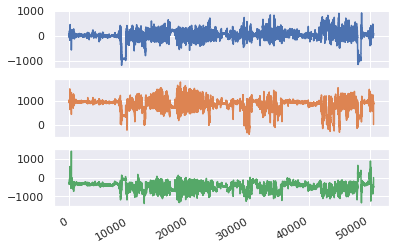

In [ ]:
_ = adl[BACK_acc].plot(subplots = True, legend = False)

# Preprocessing

## Signal processing

In [ ]:
def filter_data(data, filter_columns) :
  """
  Splits signals in their low/high filtered components.
  Arguments:
  - data: a pd.DataFrame containing signals, with no N/A values
  - filter_columns: a list of indices corresponding to the columns to filter
  Returns:
  - a pd.DataFrame with |columns| + |filter_columns| columns, since filtered
    columns are doubled
  """
  # 0.2 is 0.2 * NyquistFr = 3Hz
  hi_pass = signal.butter(5, 0.2, btype = 'highpass', output='sos', fs = 30)
  lo_pass = signal.butter(5, 0.2, btype = 'lowpass', output='sos', fs = 30)

  hi_filt = data.loc[:, filter_columns].apply(lambda sig: signal.sosfilt(hi_pass, sig))
  hi_filt.columns = ['hi' + str(name) for name in hi_filt.columns]

  lo_filt = data.loc[:, filter_columns].apply(lambda sig: signal.sosfilt(lo_pass, sig))
  lo_filt.columns = ['lo' + str(name) for name in lo_filt.columns]

  data = data.drop(columns = filter_columns)
  
  return pd.concat([data, hi_filt, lo_filt], axis = 'columns')

In [ ]:
def transform_data(data, filter_columns = []) :
  """
  Compute accelerometer inclination angles for low filtered columns.
  Arguments:
  - data: pd.DataFrame
  - filter_columns: list containing list of filtered columns
  Returns:
  - data: pd.DataFrame with accelerometer inclination angles in the last columns
  """
  
  # To avoid useless computation
  if filter_columns = [] :
    return data

  start = list(data.columns).index('lo' + str(filter_columns[0]))
  for i in range(0, len(filter_columns), 3) :
    triplet = data.iloc[:, start + i : start + i + 3].values
    norm = np.linalg.norm(triplet, axis = 1)
    if np.linalg.norm(norm) <= 1e-25 :
      triplet = np.zeros(triplet.shape)
    else :
      triplet = (triplet.T / norm).T
      triplet = np.arccos(triplet)
    data['ang_' + str(filter_columns[i])] = triplet[:,0] 
    data['ang_' + str(filter_columns[i+1])] = triplet[:,1]
    data['ang_' + str(filter_columns[i+2])] = triplet[:,2]
  return data

In [ ]:
def process_data(data, filter_columns = [], alt = False) :
  """
  Fix missing values using ffill (uses the first available value, if the firs
  value is N/A, 0 if all the columns are N/A) and filter the selected columns.
  Arguments:
  - data: a pd.DataFrame to process
  - filter_columns: a list of indices corresponding to the columns to filter

  Returns:
  - data: a pd.DataFrame with no N/A values, having |columns| + |filter_columns|
    columns, since filtered columns are doubled
  """

  data = data.copy()

  # Iterate over columns
  for column in range(data.shape[1]) :
    # If the first element is NA we look for the first non zero one
    if np.isnan(data.iloc[0,column]) :
      first_non_zero = np.argmax(data.iloc[:,column].notna())
      # Then we set the first element to the latter's value
      #return first_non_zero, column
      data.iloc[0, column] = data.iloc[first_non_zero, column]
    
    # Now we can fill forward without worries...
    data.iloc[:,column] = data.iloc[:,column].fillna(method='ffill')
    
    # ...except all the column is NA! In this case we set it entirely to zero
    if np.isnan(data.iloc[0,column]) :
      data.iloc[:,column] = np.zeros(data.shape[0])

  data = filter_data(data, filter_columns)

  #data = transform_data(data, filter_columns)

  if alt :
    data = pd.DataFrame({'mean' : data.mean(axis = 'index'),
                         'std' : data.std(axis = 'index'),
                         'min' : data.min(axis = 'index'),
                         'max' : data.max(axis = 'index'),
                         'minmax' : data.max(axis = 'index') - data.min('index'),
                         })

  return data

## Segmentation and saving

In [ ]:
def generate_dataset(file_names, window_size, columns, label, 
                     filter_columns = [], label_criterion = 'mode', alt = False) :
  """
  Arguments:
  - file_names: reference list for dataset files paths
  - window_size: integer, corresponds the size of each segment. It also determi-
    nes the stride, which is set to window_size // 2
  - columns: a list containing the indices of columns to consider. They can be
    easily selected later on, slicing on columns of the returned tensor X
  - label: integer, the index of the target column
  - filter_columns: a list of indices of the column to split in low and high
    frequencies using the function filter_data
  - label_criterion: a string in ('mode', 'last'), allows to choose if each
    segment label is decided after the mode or last sample of label

  Returns:
  - X: a tf.Tensor with shape (total_segments, window_size, features)
  - y: a tf.Tensor with shape (total_segments, n_categories)

  Raises:
  - Exception if label_criterion is not in ('mode', 'last')
  """                   

  X = []
  y = []

  for file_name in tqdm(file_names) :

    df = pd.read_csv(file_name, header = None, sep = ' ')
    
    for start in range(0, df.shape[0] - window_size, window_size // 2) :
      
      X.append(process_data(df.loc[start : start+window_size-1, columns].reset_index(),
               filter_columns, alt))
      
      if label_criterion == 'mode' :
        y.append(df.loc[start : start + window_size - 1, label].mode()[0])
      elif label_criterion == 'last' :
        y.append(df.loc[start + window_size - 1, label])
      else :
        raise Exception('Label criterion must be among "mode" and "last". \
                         You entered: {label_criterion}.')
  
  # Slices remove index
  X_columns = X[-1].columns.tolist()[1:]
  if alt :
    X = np.dstack(X).transpose(2,0,1)[:,1:,:]
  else :
    X = np.dstack(X).transpose(2,0,1)[:,:,1:]

  y = np.array(pd.get_dummies(y))

  return X_columns, filter_columns, X, y

We can generate the dataset(s) now. Pay attention:
* if `alt=False` the functions will generate datasets using standard preprocessing, thus preserving the time structure;
* if `alt=True` they will generate the alternative datasets, computing statistics to substitute time series.

Notice also that there's the possibility to early select features to get lighter dataset pickle files and to save generation time. Nevertheless, further feature selection can be done also in the Model notebook. This can be useful to generate the dataset only once and then painlessly experiment various subset of features.

In [ ]:
# Train-validation-test split, according to the reference paper
file_names_test = list(np.array(file_names)[[9, 10, 15, 16]])
file_names_valid = list(np.array(file_names)[[3, 4, -2, -3]])
file_names_train = list(set(file_names) - set(file_names_test) -set(file_names_valid))
file_names_train.sort()

In [ ]:
# Parameters
window_size = 30 # 1s
label = 243 # Locomotion
columns = BODY_acc + BODY_IMU_acc + SHOES
filter_columns = BODY_acc + BODY_IMU_acc
alt = False

In [ ]:
dataset_train = generate_dataset(file_names_train, window_size, columns, label,
                                 filter_columns, label_criterion='mode', alt=alt)
dataset_valid = generate_dataset(file_names_valid, window_size, columns,
                                 label, filter_columns, label_criterion='mode')
dataset_test = generate_dataset(file_names_test, window_size, columns,
                                 label, filter_columns, label_criterion='mode')

Let's store the dataset(s) for future use.

In [ ]:
DATASET_NAME = 'dataset'

In [ ]:
import pickle

with open(DIR_PATH + 'dataset/' + DATASET_NAME + '_train', 'wb') as file :
  pickle.dump(dataset_train, file)
with open(DIR_PATH + 'dataset/' + DATASET_NAME + '_valid', 'wb') as file :
  pickle.dump(dataset_valid, file)
with open(DIR_PATH + 'dataset/' + DATASET_NAME + '_test', 'wb') as file :
  pickle.dump(dataset_test, file)

The next part, model design and training, is `Models.ipynb` if running in local or [here](https://colab.research.google.com/drive/11YslYdPONF6ajAnnB-actRCkZrFdelp_?usp=sharing) if using Colab.